In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

Using TensorFlow backend.


In [2]:
import seaborn as sns

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})

# Load dataset
dataset_zip = np.load('dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
                      , encoding='bytes')

print('Keys in the dataset:', dataset_zip.keys())
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
metadata = dataset_zip['metadata'][()]

Keys in the dataset: KeysView(<numpy.lib.npyio.NpzFile object at 0x7f377bc8fb70>)


In [3]:
# Define number of values per latents and functions to convert to indices
latents_sizes =  np.array([ 1,  3,  6, 40, 32, 32])
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

def latent_to_index(latents):
  return np.dot(latents, latents_bases).astype(int)

def sample_latent(size=1):
  samples = np.zeros((size, latents_sizes.size))
  for lat_i, lat_size in enumerate(latents_sizes):
    samples[:, lat_i] = np.random.randint(lat_size, size=size)

  return samples

In [4]:
# Helper function to show images
def show_images_grid(imgs_, num_images=25):
  ncols = int(np.ceil(num_images**0.5))
  nrows = int(np.ceil(num_images / ncols))
  _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
  axes = axes.flatten()

  for ax_i, ax in enumerate(axes):
    if ax_i < num_images:
      ax.imshow(imgs_[ax_i], cmap='Greys_r',  interpolation='nearest')
      ax.set_xticks([])
      ax.set_yticks([])
    else:
      ax.axis('off')

def show_density(imgs):
  _, ax = plt.subplots()
  ax.imshow(imgs.mean(axis=0), interpolation='nearest', cmap='Greys_r')
  ax.grid('off')
  ax.set_xticks([])
  ax.set_yticks([])

In [5]:
# Sample latents randomly
from copy import deepcopy
## Fix posX latent to left
#latents_sampled = deepcopy(latents_classes)
#latents_sampled[:, [4,5]] = 15
#latents_sampled[:,2]= 5


np.random.seed(69)
latents_sampled = sample_latent(size=10000)

# Select images
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]

# Show images
#show_images_grid(imgs_sampled)

In [6]:
imgs_sampled.shape
print(np.unique(indices_sampled))
print(indices_sampled)

[   128    357    414 ... 737122 737193 737242]
[727276 439470 697279 ... 140719  78476 140125]


In [7]:
indices_sampled.shape

(10000,)

In [8]:
import random
random.seed(69)
ff = imgs_sampled
n_data =  ff.shape[0]
n_train = int(np.ceil(n_data*0.8))

print(n_train)
idx_train = random.sample(range(n_data), n_train)
idx_test = np.delete(range(n_data),idx_train,0)

8000


In [9]:
# split data into train / validation folds
#np.random.seed(42)

img_rows = ff.shape[1]
img_cols = ff.shape[2]

n_pixels = img_rows * img_cols
x_train = ff[idx_train]
x_test = ff[idx_test]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32') 
x_train = x_train.reshape((len(x_train), n_pixels))
x_test = x_test.reshape((len(x_test), n_pixels))

In [10]:
x_train.shape

(8000, 4096)

In [11]:
x_test.shape

(2000, 4096)

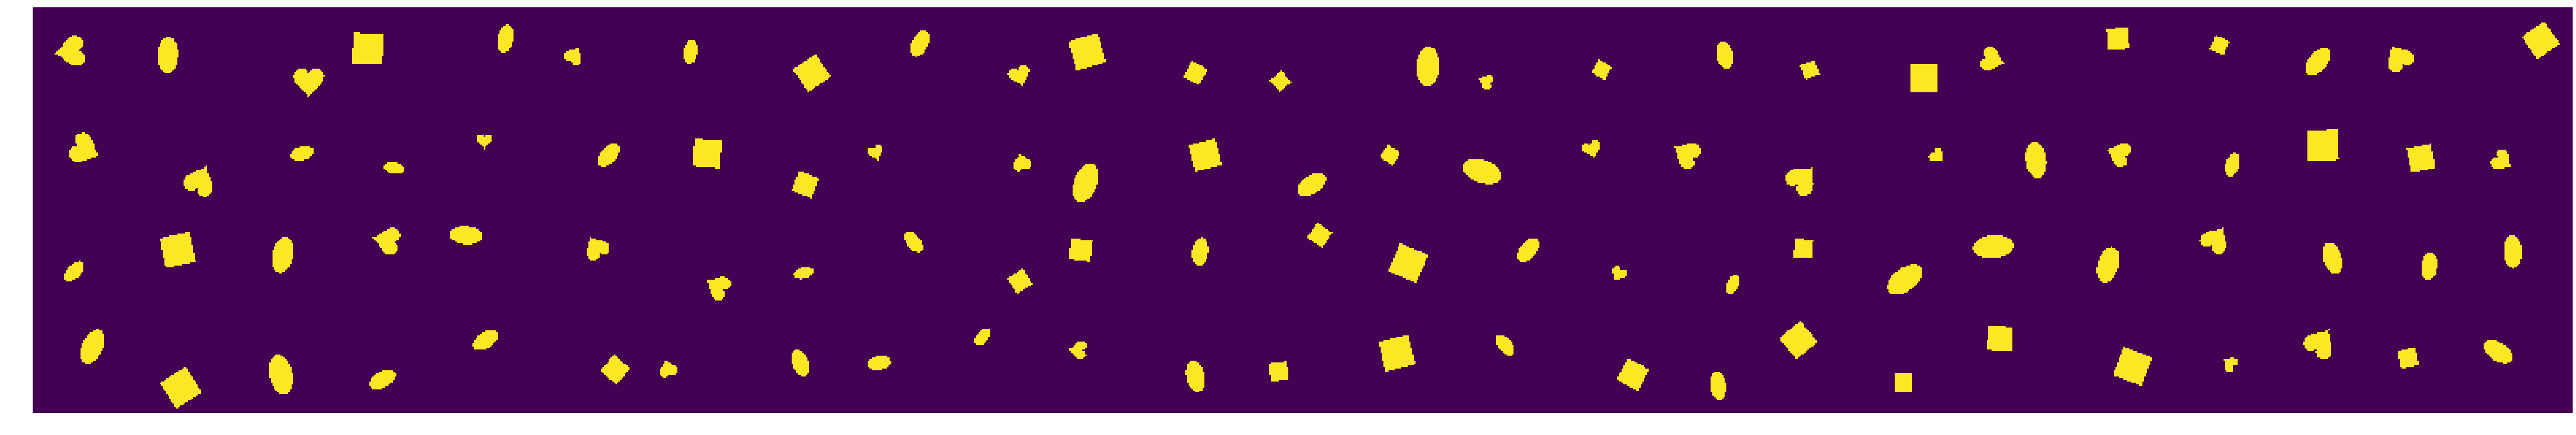

In [12]:
def show_examples(data, n=None, n_cols=20, thumbnail_cb=None):
    if n is None:
        n = len(data)    
    n_rows = int(np.ceil(n / float(n_cols)))
    figure = np.zeros((img_rows * n_rows, img_cols * n_cols))
    for k, x in enumerate(data[:n]):
        r = k // n_cols
        c = k % n_cols
        figure[r * img_rows: (r + 1) * img_rows,
               c * img_cols: (c + 1) * img_cols] = x
        if thumbnail_cb is not None:
            thumbnail_cb(locals())
        
    plt.figure(figsize=(64, 64))
    plt.imshow(figure)
    plt.axis("off")
    plt.tight_layout()
show_examples(ff, n=100, n_cols=25)

In [13]:
import tensorflow as tf
sess = tf.Session()

K.set_session(sess)

In [14]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)

    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon
#     return z_mean + K.exp(0.5 ) * epsilon

In [15]:
def plot_results(models,
                 latent_dim,
                 latent_num,
                 z_m_m, 
                 batch_size=128,
                 model_name="vae_face"):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    #x_test = data
    latent_dim = latent_dim
    os.makedirs(model_name, exist_ok=True)

    
    
    """filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()
    """

    filename = os.path.join(model_name, "face_over_latent.png")
    n = 20
    #digit_size = 28
    img_rows, img_cols = 64, 64
    figure = np.zeros((img_rows , img_cols * n))
    grid_x = np.linspace(-5, 5, n)
    #grid_x = np.linspace(-2, 2, n)
    
    #grid_y = np.linspace(-5, 5, n)[::-1]
    z_sample = np.zeros((1,latent_dim))
    z_sample[0,:] = z_m_m 
    
    for j, xi in enumerate(grid_x):
        z_sample[0,latent_num] = xi
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_rows, img_cols)
        figure[0: img_rows,j * img_cols: (j + 1) * img_cols] = digit

    plt.figure(figsize=(20, 20))
    #start_range = digit_size // 2
    #end_range = n * digit_size + start_range + 1
    #pixel_range = np.arange(start_range, end_range, digit_size)
    #sample_range_x = np.round(grid_x, 1)
    #sample_range_y = np.round(grid_y, 1)
    #plt.xticks(pixel_range, sample_range_x)
    #plt.yticks(pixel_range, sample_range_y)
    #plt.xlabel("z[0]")
    #plt.ylabel("z[1]")
    plt.axis('off')
    plt.imshow(figure, cmap='gray')
    plt.savefig(filename)
    plt.show()

In [16]:
# network parameters
original_dim = n_pixels
input_shape = (original_dim, )
intermediate_dim1 = 512
intermediate_dim2 = 256
intermediate_dim3 = 64

batch_size = 100
latent_dim = 5
epochs = 100

In [17]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x1 = Dense(intermediate_dim1, activation='relu')(inputs)
x2 = Dense(intermediate_dim2, activation='relu')(x1)
x3 = Dense(intermediate_dim3, activation='relu')(x2)

z_mean = Dense(latent_dim, name='z_mean')(x3)
z_log_var = Dense(latent_dim, name='z_log_var')(x3)


In [18]:
# standardize the mean of z, so that mean(m_z)=0 and cov(m_z)=I
def standardize(z_mean):
    z_m_m = K.mean(z_mean,axis=0, keepdims=True)
    z1 = z_mean - z_m_m
    n = tf.cast(K.shape(z_mean)[0], tf.float32)
    cov = K.transpose(z1) @ z1 /n
    
    D = tf.diag(tf.diag_part(cov)) ** 0.5
    
    L = tf.linalg.inv(tf.transpose(tf.cholesky(cov)))
       
#     z2 = z1 @ L @ D +  z_m_m
    z2 = z1 @ L  +  z_m_m

    return( z2)

In [19]:
z_mean_std = Lambda(standardize, output_shape=(latent_dim,), name='z_mean_std')(z_mean)

In [20]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
#z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean_std, z_log_var])
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 4096)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          2097664     encoder_input[0][0]              
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          131328      dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 64)           16448       dense_2[0][0]                    
__________________________________________________________________________________________________
z_mean (De

In [21]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z')

x3 = Dense(intermediate_dim3, activation='relu')(latent_inputs)
x2 = Dense(intermediate_dim2, activation='relu')(x3)
x1 = Dense(intermediate_dim1, activation='relu')(x2)

# x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x1)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z (InputLayer)               (None, 5)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                384       
_________________________________________________________________
dense_5 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_7 (Dense)              (None, 4096)              2101248   
Total params: 2,249,856
Trainable params: 2,249,856
Non-trainable params: 0
_________________________________________________________________


In [22]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [23]:
models = (encoder, decoder)
data = (x_test )

# VAE loss = mse_loss or xent_loss + kl_loss

#     reconstruction_loss = mse(inputs, outputs)
reconstruction_loss = binary_crossentropy(inputs,
                                              outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 4096)              0         
_________________________________________________________________
encoder (Model)              [(None, 5), (None, 5), (N 2246090   
_________________________________________________________________
decoder (Model)              (None, 4096)              2249856   
Total params: 4,495,946
Trainable params: 4,495,946
Non-trainable params: 0
_________________________________________________________________


In [24]:
epochs = int(1E3)

In [25]:
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 8000 samples, validate on 2000 samples
Epoch 1/1000
8000/8000 [==============================] - 2s 244us/step - loss: 751.7329 - val_loss: 384.3394
Epoch 2/1000
8000/8000 [==============================] - 1s 127us/step - loss: 282.3452 - val_loss: 209.4776
Epoch 3/1000
8000/8000 [==============================] - 1s 127us/step - loss: 192.6052 - val_loss: 184.7104
Epoch 4/1000
8000/8000 [==============================] - 1s 127us/step - loss: 173.8477 - val_loss: 163.9911
Epoch 5/1000
8000/8000 [==============================] - 1s 127us/step - loss: 159.6183 - val_loss: 151.5562
Epoch 6/1000
8000/8000 [==============================] - 1s 126us/step - loss: 153.5643 - val_loss: 151.8977
Epoch 7/1000
8000/8000 [==============================] - 1s 126us/step - loss: 152.0235 - val_loss: 150.7820
Epoch 8/1000
8000/8000 [==============================] - 1s 127us/step - loss: 150.1899 - val_loss: 147.2587
Epoch 9/1000
8000/8000 [==============================] - 1s 127us/step 

8000/8000 [==============================] - 1s 126us/step - loss: 116.4077 - val_loss: 123.2775
Epoch 75/1000
8000/8000 [==============================] - 1s 128us/step - loss: 117.9908 - val_loss: 123.5179
Epoch 76/1000
8000/8000 [==============================] - 1s 128us/step - loss: 118.7283 - val_loss: 124.6084
Epoch 77/1000
8000/8000 [==============================] - 1s 126us/step - loss: 118.2094 - val_loss: 122.0129
Epoch 78/1000
8000/8000 [==============================] - 1s 126us/step - loss: 117.3974 - val_loss: 121.8039
Epoch 79/1000
8000/8000 [==============================] - 1s 127us/step - loss: 118.3616 - val_loss: 123.5255
Epoch 80/1000
8000/8000 [==============================] - 1s 126us/step - loss: 117.2510 - val_loss: 124.2999
Epoch 81/1000
8000/8000 [==============================] - 1s 126us/step - loss: 118.0571 - val_loss: 126.0857
Epoch 82/1000
8000/8000 [==============================] - 1s 127us/step - loss: 116.4503 - val_loss: 123.0854
Epoch 83/1000
8

8000/8000 [==============================] - 1s 126us/step - loss: 107.4345 - val_loss: 118.2749
Epoch 148/1000
8000/8000 [==============================] - 1s 127us/step - loss: 106.9271 - val_loss: 118.8936
Epoch 149/1000
8000/8000 [==============================] - 1s 125us/step - loss: 106.2912 - val_loss: 120.1355
Epoch 150/1000
8000/8000 [==============================] - 1s 128us/step - loss: 106.6723 - val_loss: 118.8806
Epoch 151/1000
8000/8000 [==============================] - 1s 127us/step - loss: 106.6107 - val_loss: 119.4964
Epoch 152/1000
8000/8000 [==============================] - 1s 127us/step - loss: 106.8648 - val_loss: 119.0809
Epoch 153/1000
8000/8000 [==============================] - 1s 127us/step - loss: 105.3223 - val_loss: 121.6434
Epoch 154/1000
8000/8000 [==============================] - 1s 127us/step - loss: 105.2292 - val_loss: 119.1143
Epoch 155/1000
8000/8000 [==============================] - 1s 127us/step - loss: 105.1758 - val_loss: 119.8524
Epoch 1

8000/8000 [==============================] - 1s 127us/step - loss: 100.1197 - val_loss: 118.1962
Epoch 221/1000
8000/8000 [==============================] - 1s 126us/step - loss: 97.8456 - val_loss: 121.1790
Epoch 222/1000
8000/8000 [==============================] - 1s 126us/step - loss: 99.7857 - val_loss: 121.7527
Epoch 223/1000
8000/8000 [==============================] - 1s 127us/step - loss: 96.7237 - val_loss: 118.8572
Epoch 224/1000
8000/8000 [==============================] - 1s 126us/step - loss: 96.3968 - val_loss: 120.7141
Epoch 225/1000
8000/8000 [==============================] - 1s 126us/step - loss: 96.4441 - val_loss: 118.7139
Epoch 226/1000
8000/8000 [==============================] - 1s 125us/step - loss: 96.3919 - val_loss: 118.8686
Epoch 227/1000
8000/8000 [==============================] - 1s 128us/step - loss: 97.6896 - val_loss: 121.7674
Epoch 228/1000
8000/8000 [==============================] - 1s 127us/step - loss: 96.6176 - val_loss: 121.1392
Epoch 229/1000


Epoch 294/1000
8000/8000 [==============================] - 1s 126us/step - loss: 92.0816 - val_loss: 121.7911
Epoch 295/1000
8000/8000 [==============================] - 1s 126us/step - loss: 94.3505 - val_loss: 123.2945
Epoch 296/1000
8000/8000 [==============================] - 1s 127us/step - loss: 92.1688 - val_loss: 127.2888
Epoch 297/1000
8000/8000 [==============================] - 1s 127us/step - loss: 90.8686 - val_loss: 123.8967
Epoch 298/1000
8000/8000 [==============================] - 1s 127us/step - loss: 90.9925 - val_loss: 125.0858
Epoch 299/1000
8000/8000 [==============================] - 1s 127us/step - loss: 91.8004 - val_loss: 127.3598
Epoch 300/1000
8000/8000 [==============================] - 1s 127us/step - loss: 93.4623 - val_loss: 124.4188
Epoch 301/1000
8000/8000 [==============================] - 1s 127us/step - loss: 91.5462 - val_loss: 123.6149
Epoch 302/1000
8000/8000 [==============================] - 1s 127us/step - loss: 90.6377 - val_loss: 122.5741
E

KeyboardInterrupt: 

In [26]:
z_output = sess.run( z_mean_std, feed_dict={'encoder_input: 0':x_train})

In [27]:
z_m_m = np.mean(z_output,axis=0)
z_m_m

array([-0.02517061, -0.01163616, -0.01488229, -0.04596819,  0.02304631],
      dtype=float32)

In [28]:
np.cov(z_output.T)

array([[ 1.00012485e+00,  8.55187435e-10, -2.30193898e-09,
         8.17014526e-10,  2.59333411e-09],
       [ 8.55187435e-10,  1.00012493e+00,  4.29940414e-09,
         1.88842635e-09, -2.76222134e-09],
       [-2.30193898e-09,  4.29940414e-09,  1.00012510e+00,
         5.22336352e-09,  1.94685459e-09],
       [ 8.17014526e-10,  1.88842635e-09,  5.22336352e-09,
         1.00012498e+00,  2.31351367e-09],
       [ 2.59333411e-09, -2.76222134e-09,  1.94685459e-09,
         2.31351367e-09,  1.00012519e+00]])

Plot the Pearson correlation among Z

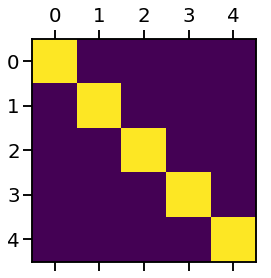

In [29]:
plt.matshow(np.corrcoef(z_output.T))

In [30]:
z_m_m

array([-0.02517061, -0.01163616, -0.01488229, -0.04596819,  0.02304631],
      dtype=float32)

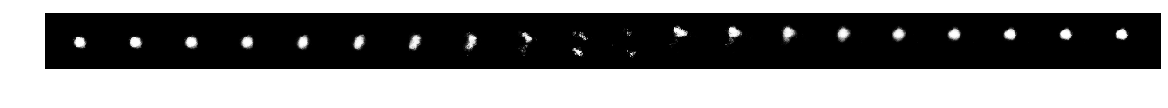

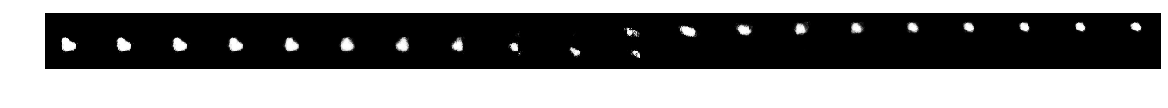

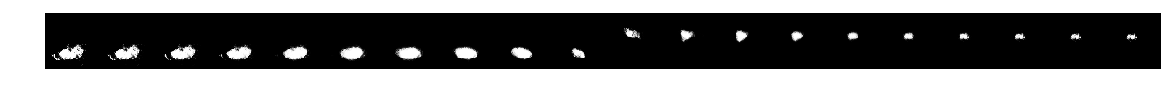

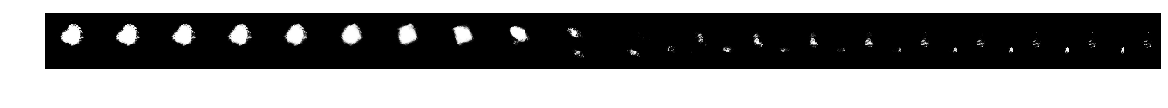

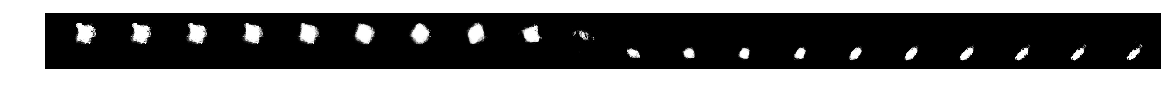

In [31]:
for i in range(0, latent_dim):
    plot_results(models,
                 latent_dim,
                 latent_num = i,
                 z_m_m = z_m_m ,
                 batch_size=batch_size,
                 model_name="vae_mlp")